In [1]:
DEMOGRAPHICS_PATIENTS = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/ShunSasai_SCP_clean/scripts/utils/subj_list/subject_list_patient_COBRE.mat'
DEMOGRAPHICS_CONTROLS = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/ShunSasai_SCP_clean/scripts/utils/subj_list/subject_list_control_COBRE.mat'
STRUCTURAL_DERIVATIVES = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/Schizconnect_raw_data/COBRE/COBREqsirecon/derivatives/qsirecon-MRtrix3_fork-SS3T_act-HSVS'
FUNCTIONAL_DERIVATIVES = '/run/user/1000/gvfs/sftp:host=tononi-1/Volumes/White_Elephant/Schizophrenia/Schizconnect_raw_data/COBRE/COBRExcpd/'
# ATLASES = ['4S156', '4S256', '4S456']
ATLASES = ['4S156']
ATLAS = ATLASES[0]

def print2(expression: str):
    print('>>> ' + expression)
    print(eval(expression))
    print()

In [3]:
%%time

from bids import BIDSLayout, BIDSLayoutIndexer

indexer = BIDSLayoutIndexer(validate=False, index_metadata=False)

structural_derivatives = BIDSLayout(
    STRUCTURAL_DERIVATIVES,
    indexer=indexer,
)

functional_derivatives = BIDSLayout(
    FUNCTIONAL_DERIVATIVES,
    indexer=indexer,
)

CPU times: user 9.99 s, sys: 407 ms, total: 10.4 s
Wall time: 39 s


In [4]:
import importlib
import schiz_wholebrain
importlib.reload(schiz_wholebrain)
from schiz_wholebrain.subject import Subject

# A `Subject` is made of a subject label and (optionally) connectivity
# and demographics data:

A00024160 = Subject(
    'A00024160',
    structural_session_label = '20090101',
    structural_derivatives = structural_derivatives.root,
    functional_session_label = '20090101',
    functional_derivatives = functional_derivatives.root,
    atlases = ATLASES,
    demographics = {'diagnosis': 'sick', 'country': 'XYZ', 'height': 1.8},
)

print2('A00024160')
print2('A00024160.demographics')

print2('A00024160.functional_session')
print2('A00024160.functional_connectivity[ATLAS]')
print2('A00024160.structural_session')
print2('A00024160.structural_connectivity[ATLAS]')


>>> A00024160
Subject(A00024160, 1)

>>> A00024160.demographics
{'diagnosis': 1, 'country': 'XYZ', 'height': 1.8}

>>> A00024160.functional_session
20090101

>>> A00024160.functional_connectivity[ATLAS]
FunctionalConnectivity

>>> A00024160.structural_session
20090101

>>> A00024160.structural_connectivity[ATLAS]
StructuralConnectivity



In [13]:
import importlib
from schiz_wholebrain.cohort import Cohort
importlib.reload(schiz_wholebrain)
from schiz_wholebrain.cohort import Cohort

# Cohorts can be created by passing an Iterable of Subjects:
mycohort = Cohort([A00024160])
print2('mycohort')

# Or by calling the special method `Cohort.cohort_from_data()`, to go
# straight from data paths and BIDS layouts to a Cohort pre-filled
# with Subjects.

patients = Cohort.cohort_from_data(
    DEMOGRAPHICS_PATIENTS,
    structural_derivatives,
    functional_derivatives,
    ATLASES,
    sample_size=5,
)

 87%|████████████████████████▍   | 48/55 [1:20:49<11:47, 101.04s/it]

>>> mycohort
Cohort({Subject(A00024160, 1)})



  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▌                          | 1/5 [00:38<02:33, 38.39s/it]

 40%|█████████████▏                   | 2/5 [00:39<00:48, 16.21s/it]

 80%|██████████████████████████▍      | 4/5 [00:39<00:06,  6.11s/it]

100%|█████████████████████████████████| 5/5 [00:39<00:00,  7.86s/it]

In [14]:
controls = Cohort.cohort_from_data(
    DEMOGRAPHICS_CONTROLS,
    structural_derivatives,
    functional_derivatives,
    ATLASES,
    sample_size=5,
)

  0%|                                         | 0/5 [00:00<?, ?it/s]

 20%|██████▌                          | 1/5 [00:24<01:37, 24.44s/it]

 40%|█████████████▏                   | 2/5 [00:26<00:34, 11.35s/it]

 80%|██████████████████████████▍      | 4/5 [00:26<00:04,  4.30s/it]

100%|█████████████████████████████████| 5/5 [00:27<00:00,  3.14s/it]

100%|█████████████████████████████████| 5/5 [00:27<00:00,  5.48s/it]

In [9]:
print2("f'{len(patients)} patients and {len(controls)} controls.'")

# Cohorts also support simple indexing by label:
A00021058 = controls['A00021058']
print('A00021058')

# Cohorts behave like sets, relying on subject labels for element uniqueness:
print2('set.intersection(patients, controls)')

print2("f'{len(set.union(patients, controls))} subjects in total.'")

print2("A00021058 in controls")
# Same as:
print2("'A00021058' in controls")

>>> f'{len(patients)} patients and {len(controls)} controls.'
40 patients and 40 controls.



KeyError: 'No subject found with label: A00021058'

In [15]:
# A Cohort subset can be derived by calling `Cohort.filter()` and passing an
# arbitrary function describing the condition to be met for single subjects.
# This is syntactic sugar for:
#     `subcohort = Cohort(filter(condition, cohort))`

def filter_by_motion(subject):
    threshold = 0.5
    return subject.functional_connectivity[ATLAS].motion_outliers_ratio < threshold

low_motion_patients = patients.filter(filter_by_motion)
low_motion_controls = controls.filter(filter_by_motion)

print2("f'{len(low_motion_patients)} patients and {len(low_motion_controls)} controls.'")

print2('low_motion_patients.labels')

# Arbitrary Subject attributes can be easily collected for the whole Cohort...
demographics = low_motion_patients.collect("demographics", subject_labels=True)
print2('demographics')
print2('dict(list(demographics)[0:3])')

# ...this supports attributes deep-nested within Subjects:
attribute = f"connectivity_{ATLAS}.functional.motion_outliers_ratio"
print2('attribute')
print2('list(low_motion_patients.collect(attribute))')

>>> f'{len(low_motion_patients)} patients and {len(low_motion_controls)} controls.'
5 patients and 4 controls.

>>> low_motion_patients.labels
{'A00020602', 'A00014804', 'A00023750', 'A00014636', 'A00027969'}

>>> demographics
<generator object Cohort.collect at 0x7e01b9293d60>

>>> dict(list(demographics)[0:3])
{'A00020602': {'age': 22, 'sex': 'male', 'subdiagnosis': 'Schizophrenia_Strict', 'diagnosis': 'SSD'}, 'A00014804': {'age': 30, 'sex': 'male', 'subdiagnosis': 'Schizophrenia_Strict', 'diagnosis': 'SSD'}, 'A00023750': {'age': 51, 'sex': 'male', 'subdiagnosis': 'Schizophrenia_Strict', 'diagnosis': 'SSD'}}

>>> attribute
connectivity_4S156.functional.motion_outliers_ratio

>>> list(low_motion_patients.collect(attribute))
[0.07333333333333333, 0.1, 0.3466666666666667, 0.4866666666666667, 0.09333333333333334]



In [35]:
import numpy as np
import importlib
from schiz_wholebrain import quantities
importlib.reload(quantities)
from schiz_wholebrain.quantities import (
    aln_correlation, structure_function_correlation
)

# The `quantities` module contains functions which operate on whole subjects.
# `Subject.compute()` is a convenience function which automatically
# stores the result in a dictionary called `Subject.quantities`.
# A similar interface called `Cohort.compute()` exists to process and
# store the quantity in parallel for whole cohorts.

union = Cohort(set.union(low_motion_patients, low_motion_controls))

# Correlations with structural connectivity.
union.compute(structure_function_correlation)

# Correlations with simulated functional connectivity.
union.compute(aln_correlation, max_workers=18)

# Correlations with simulated functional connectivity, based on cohort's mean
# structural connectivity.

for cohort in (low_motion_patients, low_motion_controls):
    counts = cohort.collect(f"connectivity_{ATLAS}.structural.raw_count")
    lengths = cohort.collect(f"connectivity_{ATLAS}.structural.mean_length")
    mean_count = np.stack(list(counts), axis=-1).mean(axis=-1)
    mean_length = np.stack(list(lengths), axis=-1).mean(axis=-1)

    for subject in cohort:
        subject.quantities['cohort_mean_raw_count'] = mean_count
        subject.quantities['cohort_mean_mean_length'] = mean_length

union.compute(
    aln_correlation,
    key='aln_correlation_cohort_mean',
    max_workers=18,
    mean_structural=True,
)


  0%|                                         | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████| 9/9 [00:00<00:00, 256.97it/s]

  0%|                                         | 0/9 [00:00<?, ?it/s]

 11%|███▌                            | 1/9 [02:57<23:41, 177.64s/it]

 22%|███████▎                         | 2/9 [03:14<09:40, 83.00s/it]

 33%|███████████                      | 3/9 [03:14<04:31, 45.28s/it]

 44%|██████████████▋                  | 4/9 [03:16<02:20, 28.02s/it]

 56%|██████████████████▎              | 5/9 [03:20<01:17, 19.26s/it]

 67%|██████████████████████           | 6/9 [03:21<00:39, 13.18s/it]

 78%|█████████████████████████▋       | 7/9 [03:23<00:19,  9.68s/it]

 89%|█████████████████████████████▎   | 8/9 [03:27<00:07,  7.72s/it]

100%|█████████████████████████████████| 9/9 [03:29<00:00,  6.01s/it]

100%|█████████████████████████████████| 9/9 [03:29<00:00, 23.30s/it]

  0%|                                         | 0/9 [00:00<?, ?it/s]

 11%|███▌                            | 1/9 [03:41<29:30, 221.31s/it]

 22%|███████▎                         | 2/9 [03:41<10:40, 91.47s/it]

 33%|███████████                      | 3/9 [03:49<05:20, 53.39s/it]

 44%|██████████████▋                  | 4/9 [03:53<02:48, 33.66s/it]

 56%|██████████████████▎              | 5/9 [03:59<01:35, 23.90s/it]

 67%|██████████████████████           | 6/9 [04:02<00:49, 16.57s/it]

 78%|█████████████████████████▋       | 7/9 [04:04<00:23, 11.98s/it]

 89%|█████████████████████████████▎   | 8/9 [04:05<00:08,  8.43s/it]

100%|█████████████████████████████████| 9/9 [04:05<00:00,  5.85s/it]

100%|█████████████████████████████████| 9/9 [04:05<00:00, 27.32s/it]

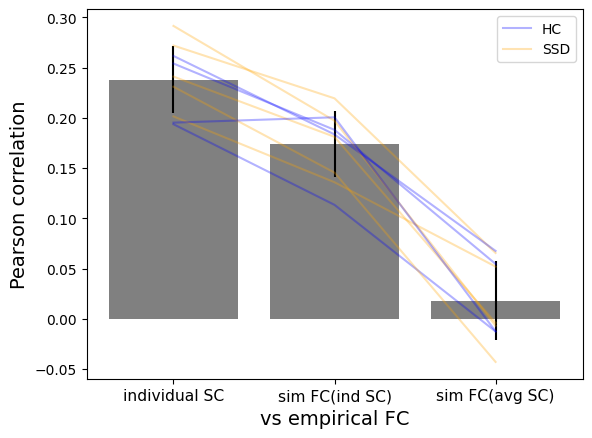

In [36]:
import importlib
import schiz_wholebrain.plot
importlib.reload(schiz_wholebrain.plot)
from schiz_wholebrain import plot

correlations_sc = dict(
    union.collect(
        "quantities[structure_function_correlation]",
        subject_labels=True,
    )
)

correlations_sim = dict(
    union.collect(
        "quantities[aln_correlation]",
        subject_labels=True,
    )
)

correlations_sim_cohort_mean = dict(
    union.collect(
        "quantities[aln_correlation_cohort_mean]",
        subject_labels=True,
    )
)

measures = {
    'individual SC': correlations_sc,
    'sim FC(ind SC)': correlations_sim,
    'sim FC(avg SC)': correlations_sim_cohort_mean,
}

colors = {
    subject.label: 'blue' if subject.demographics['diagnosis'] == 'HC' else 'orange'
    for subject in union
}
groups = {subject.label: subject.demographics['diagnosis'] for subject in union}

plot.repeated_measures(
    measures,
    subject_colors=colors,
    subject_groups=groups,
    ylabel="Pearson correlation",
    xlabel="vs empirical FC"
)

In [27]:
import importlib
from schiz_wholebrain import quantities
importlib.reload(quantities)
from schiz_wholebrain.quantities import fcs

low_motion_patients.compute(fcs, absolute=False)
low_motion_controls.compute(fcs, absolute=False)

low_motion_patients

fcs_controls = np.array(list(low_motion_controls.collect("quantities[fcs]")))
fcs_patients = np.array(list(low_motion_patients.collect("quantities[fcs]")))

  0% 0/17 [00:00<?, ?it/s]

100% 17/17 [00:00<00:00, 523.04it/s]

  0% 0/19 [00:00<?, ?it/s]

100% 19/19 [00:00<00:00, 618.48it/s]

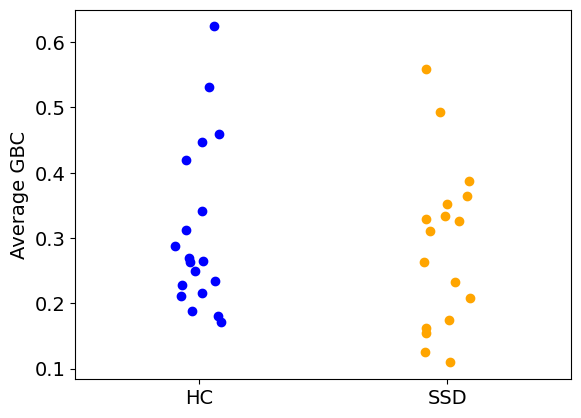

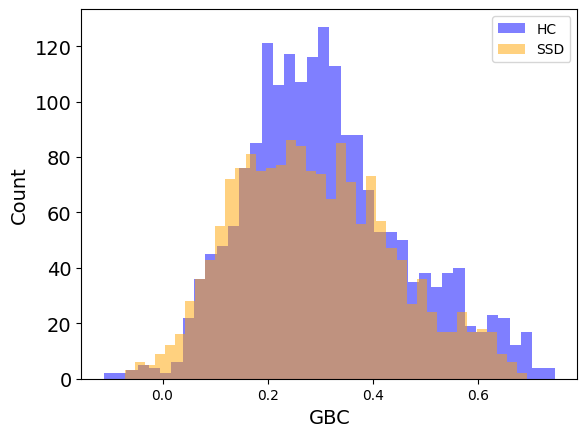

In [22]:
import importlib
import schiz_wholebrain.plot
importlib.reload(schiz_wholebrain.plot)
from schiz_wholebrain import plot

plot.scatter(
    [brain.mean(axis=0) for brain in fcs_controls],
    [brain.mean(axis=0) for brain in fcs_patients],
    ylabel="Average GBC",
)

plot.density(
    np.concatenate(fcs_controls),
    np.concatenate(fcs_patients),
    xlabel="GBC",
    ylabel="Count",
)

In [39]:
import numpy as np

fourier_patients = [
    np.fft.fft(subject.functional_connectivity[ATLAS].time_series, axis=0)
    for subject in low_motion_patients
]

fourier_controls = [
    np.fft.fft(subject.functional_connectivity[ATLAS].time_series, axis=0)
    for subject in low_motion_controls
]

sample_rate = 2                 # Seconds
nyquist_freq = (1 / sample_rate) / 2

band = [0.04, 0.07]

narrowband_patients = []

# for patient in patients:
#     freq = np.fft.fftfreq(patient.shape[0], sample_rate)
#     mask = np.logical_and(band[0] < np.abs(freq), np.abs(freq) < band[1])
#     filtered_fourier = patient * mask

array([ 0.00000000e+00, -1.96690027e+01, -2.96982510e+01,  1.13452310e+01,
       -2.16663775e+01,  1.47337632e+01,  3.42040914e+01,  1.75899382e+01,
       -1.84167329e+01,  1.75141964e+00,  1.99292551e+01, -1.97934634e+00,
       -3.04023024e+01,  2.65930059e+00, -1.52007891e+01, -6.64393978e+00,
        9.63626263e+00,  2.22381902e+00, -7.00874839e-01, -3.09869997e+01,
       -2.43117864e+01, -1.16512780e+01, -1.85160991e+01,  4.19165313e+00,
       -1.24733805e+01, -1.48353162e+01, -2.35668668e+00, -2.41133710e+01,
        2.01972761e+01,  1.75864675e+01,  4.29308024e+00,  1.05782299e+01,
        1.47643352e+00, -6.81364078e+00, -7.53483099e+00, -5.53874460e+00,
       -3.40380032e+00,  1.23571917e+00,  4.35760029e+00,  3.29838836e+00,
        7.46275431e-01, -8.70206574e-01, -3.32419559e+00, -4.75428069e+00,
       -2.94362911e+00, -5.70045684e-01,  8.02741771e-01,  2.53860853e+00,
        3.34811673e+00,  1.73587099e+00, -2.71819064e-02, -7.61469082e-01,
       -1.78026121e+00, -

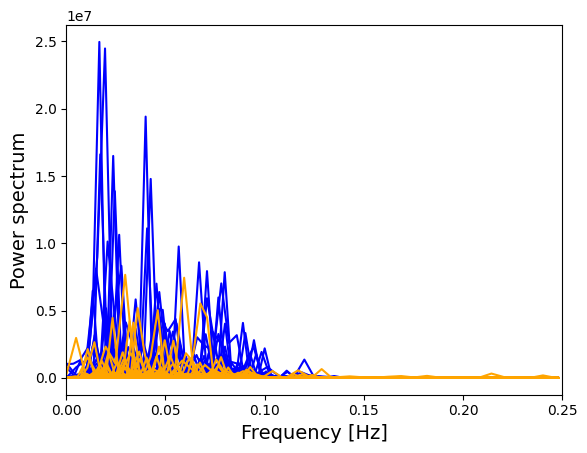

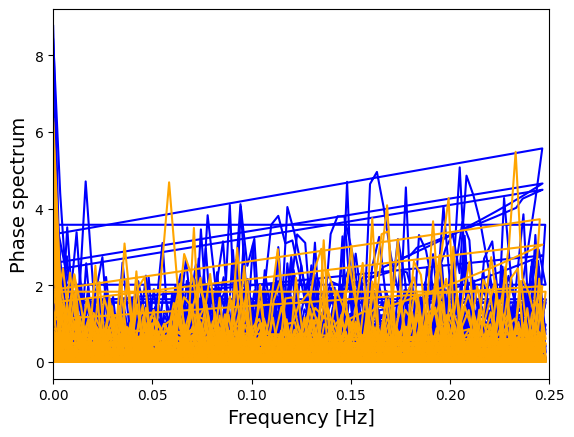

In [43]:
plot.spectrum(
    [np.abs(c.mean(axis=1)) ** 2 for c in fourier_controls],
    [np.abs(p.mean(axis=1)) ** 2 for p in fourier_patients],
    xlim=[0, nyquist_freq],
    xlabel="Frequency [Hz]",
    ylabel="Power spectrum",
)

plot.spectrum(
    [np.angle(c).mean(axis=1) for c in fourier_controls],
    [np.angle(p).mean(axis=1) for p in fourier_patients],
    xlim=[0, nyquist_freq],
    xlabel="Frequency [Hz]",
    ylabel="Phase spectrum",
)
